# Step 1 - Climate Analysis and Exploration

In [1]:
# •••••••••••••••••••••••••••••••••••••••• Dependencies and Imports •••••••••••••••••••••••••••••••••••••••••••••••••••••••• #

In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, func, MetaData, inspect

## Reflect Tables into SQLAlchemy ORM

In [3]:
# ••••••••••••••••••••••••••••••••••••••••• Database Setup ••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• #

In [4]:
# Use SQLAlchemy ◄create_engine► to connect to Hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Use SQLAlchemy ◄automap_base► to reflect your tables into classes
Base = automap_base()
Base.prepare(engine, reflect=True)

# Next, save references to the classes and name them `Station` and `Measurement`
Station = Base.classes.station
Measurement = Base.classes.measurement

In [6]:
# Create the session (link) from Python to the DB
#Session = Session(engine)
Session = sessionmaker(bind=engine)
session = Session()

In [7]:
# K, now use the inspector to check out the classes found by the automap
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Next, take a look at the column names and data types for the Measurement class
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# K, now repeat for the Station class
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Also, use engine.execute to take a look at all the values in the first 5 rows of each class
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

#engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

# Precipitation Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
precipres = session.query(Measurement.date, Measurement.prcp).filter\
(Measurement.date >= '2017-01-01').filter(Measurement.date <= '2017-12-31').order_by(Measurement.date).all()

In [12]:
# Hey Pandas, please make us a DataFrame with the query results ☺☻☺☻
precip_df = pd.DataFrame(data=precipres) 
precip_df.head()

,date,prcp
0,2017-01-01,0.00
1,2017-01-01,0.29
2,2017-01-01,0.00
3,2017-01-01,NaN
4,2017-01-01,0.03


In [13]:
# Index it by date and check it out
precip_df = precip_df.set_index('date')
precip_df.head()

,prcp
date,
2017-01-01,0.00
2017-01-01,0.29
2017-01-01,0.00
2017-01-01,NaN
2017-01-01,0.03


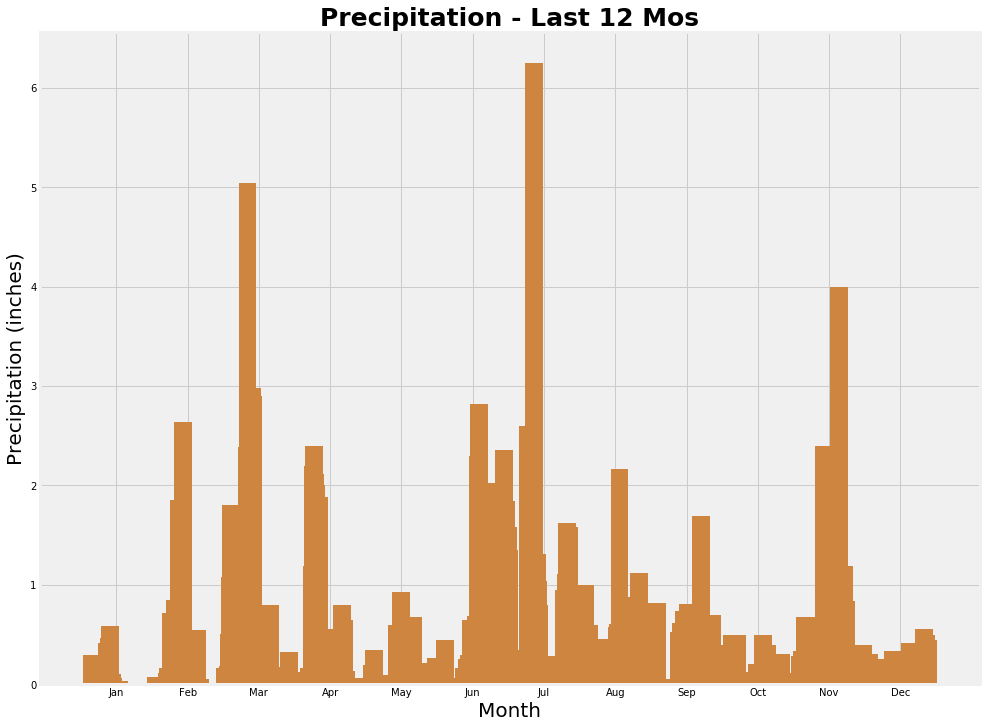

In [14]:
# ••••••••••••••••••••••••••••••••••••••••• Party like you're Matplotliberace •••••••••••••••••••••••••••••••••••••••••••••••• #
plt.figure(figsize = (15,12))
plt.title("Precipitation - Last 12 Mos", fontdict = {'fontsize': 25, 'fontweight': 'bold'})
plt.xlabel("Month", fontdict = {'fontsize': 20})
plt.ylabel("Precipitation (inches)", fontdict = {'fontsize': 20})
# Month names so x-ticks show these instead of 00-00-000
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
yval = precip_df["prcp"].tolist()
xval = np.arange(0, len(precip_df.index.tolist()), 1)
totalmon = len(yval)
monxtix = int((totalmon / 12)*1.03)
plt.ylim = max(yval) + 1
ticklox = [x+55 for x in range(1, totalmon, monxtix)]
plt.bar(xval, yval, width=30, color="peru", alpha=1, align="edge")
plt.xticks(ticklox, months)
plt.show()

In [15]:
# Finally: * Use Pandas to print the summary statistics for the precipitation data.
precip_df.describe()

,prcp
count,1267.000000
mean,0.165927
std,0.453913
min,0.000000
25%,0.000000
50%,0.000000
75%,0.105000
max,6.250000


# Station Analysis

In [16]:
# Design a query to calculate the total number of stations.
totstash = session.query(func.count(Station.station)).first()
totstash

(9)

### Station Activity - Query Requirements

In [17]:
# *Design a query to find the most active stations
# * List the stations and observation counts in descending order.
# * Which station has the highest number of observations?

In [18]:
# First, checkout the counts by station from both classes
engine.execute("SELECT count(station), station FROM measurement GROUP BY station ORDER BY count(station) DESC").fetchall()

[(2772, 'USC00519281'),
 (2724, 'USC00519397'),
 (2709, 'USC00513117'),
 (2669, 'USC00519523'),
 (2612, 'USC00516128'),
 (2202, 'USC00514830'),
 (1979, 'USC00511918'),
 (1372, 'USC00517948'),
 (511, 'USC00518838')]

In [19]:
# Now that we have the counts, we can gauge the activity and list it in descending order. 

# Query Time!
stashact = session.query(Measurement.station, func.count(Measurement.tobs)).\
        group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

# DataFrame Time!
stashact_df = pd.DataFrame(data=stashact, columns=['Station', 'Count'])
stashact_df.head()

,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612


In [20]:
# K, now show the station with the highest # of observations
stashobs = stashact_df["Station"][0]
mostobs = stashact_df["Count"][0]
print(f"Oooh! The most observations were at station ({stashobs}), with {mostobs} observations! Go Team {stashobs}! ")

Oooh! The most observations were at station (USC00519281), with 2772 observations! Go Team USC00519281! 


### Station Activity - Query Requirements

In [21]:
# * Design a query to retrieve the last 12 months of temperature observation data (tobs)
# * Filter by the station with the highest number of observations.

In [22]:
# First, query the tobs to view the last 12 months
temps = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.date > '2017-01-01').\
    order_by(Measurement.date).all()
temps

[('USC00519397', '2017-01-02', 66.0),
 ('USC00513117', '2017-01-02', 66.0),
 ('USC00514830', '2017-01-02', 74.0),
 ('USC00519281', '2017-01-02', 70.0),
 ('USC00516128', '2017-01-02', 70.0),
 ('USC00519397', '2017-01-03', 63.0),
 ('USC00513117', '2017-01-03', 65.0),
 ('USC00514830', '2017-01-03', 70.0),
 ('USC00519523', '2017-01-03', 73.0),
 ('USC00519281', '2017-01-03', 64.0),
 ('USC00516128', '2017-01-03', 71.0),
 ('USC00519397', '2017-01-04', 62.0),
 ('USC00513117', '2017-01-04', 64.0),
 ('USC00514830', '2017-01-04', 71.0),
 ('USC00519523', '2017-01-04', 73.0),
 ('USC00519281', '2017-01-04', 63.0),
 ('USC00516128', '2017-01-04', 70.0),
 ('USC00519397', '2017-01-05', 63.0),
 ('USC00513117', '2017-01-05', 65.0),
 ('USC00514830', '2017-01-05', 72.0),
 ('USC00519523', '2017-01-05', 71.0),
 ('USC00519281', '2017-01-05', 63.0),
 ('USC00516128', '2017-01-05', 71.0),
 ('USC00519397', '2017-01-06', 64.0),
 ('USC00513117', '2017-01-06', 70.0),
 ('USC00514830', '2017-01-06', 71.0),
 ('USC005195

In [23]:
# Alrighty, let's plot the results as a histogram with `bins=12`.

# First, we need a DataFrame
tobsdf = pd.DataFrame(temps, columns=['Station', 'Date', 'Temp'])
tobsdf.set_index('Station', inplace=True)
tobsdf.head()

,Date,Temp
Station,,
USC00519397,2017-01-02,66.0
USC00513117,2017-01-02,66.0
USC00514830,2017-01-02,74.0
USC00519281,2017-01-02,70.0
USC00516128,2017-01-02,70.0


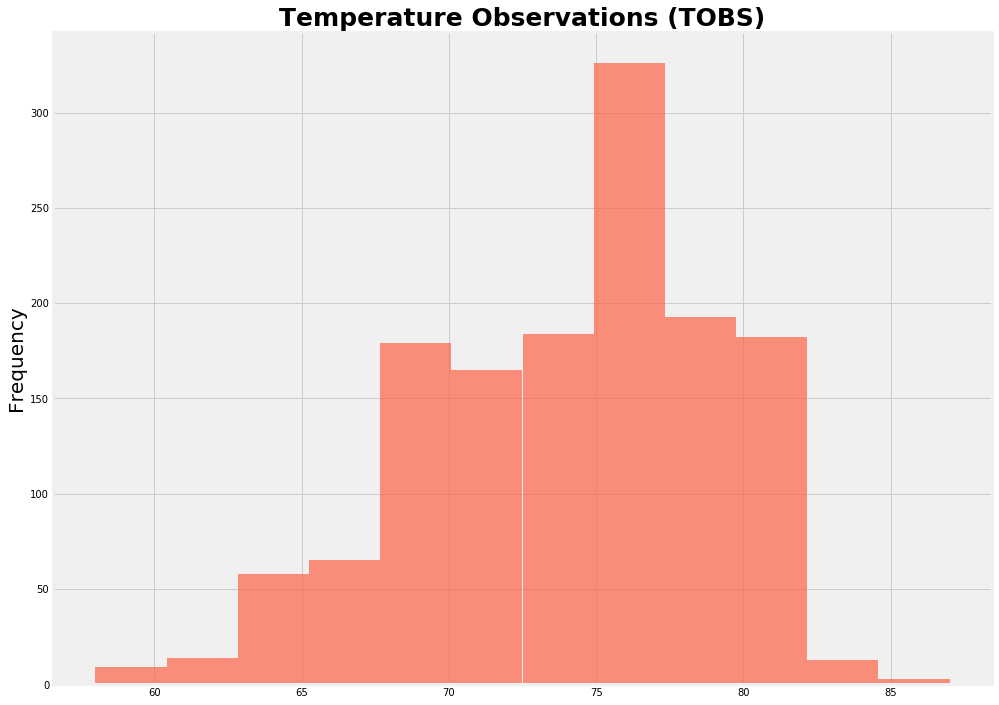

In [24]:
# •••••••••••••••••••••••••••••••••••••••••••••••• Histogram Hoolah •••••••••••••••••••••••••••••••••••••••••••••••••••••••• #
hist_plot = tobsdf['Temp'].hist(bins=12, figsize=(15,12), color='tomato', alpha=0.70)
hist_plot.set_title("Temperature Observations (TOBS)", fontdict = {'fontsize': 25, 'fontweight': 'bold'})
hist_plot.set_ylabel('Frequency', fontsize=20)
plt.show()

# Optional: Other Recommended Analyses

## Temperature Analysis

In [25]:
# The starter notebook contains a function called `calc_temps` 
# This will accept a start date and end date in the format `%Y-%m-%d`
# It will also return the minimum, average, and maximum temperatures for that range of dates.
# Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip 
# Use the matching dates from the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-01-28', '2016-02-07'))

[(64.0, 69.80882352941177, 78.0)]


In [26]:
# Ok great - now match the calculations up to my trip date
arrival = dt.date(2016, 1, 28)
departure = dt.date(2016, 2, 7)
lastyr = dt.timedelta(days=365)
yr1avgtemp = (calc_temps((arrival-lastyr), (departure-lastyr)))
print(yr1avgtemp)

[(58.0, 69.54054054054055, 77.0)]


C:\Users\janac\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


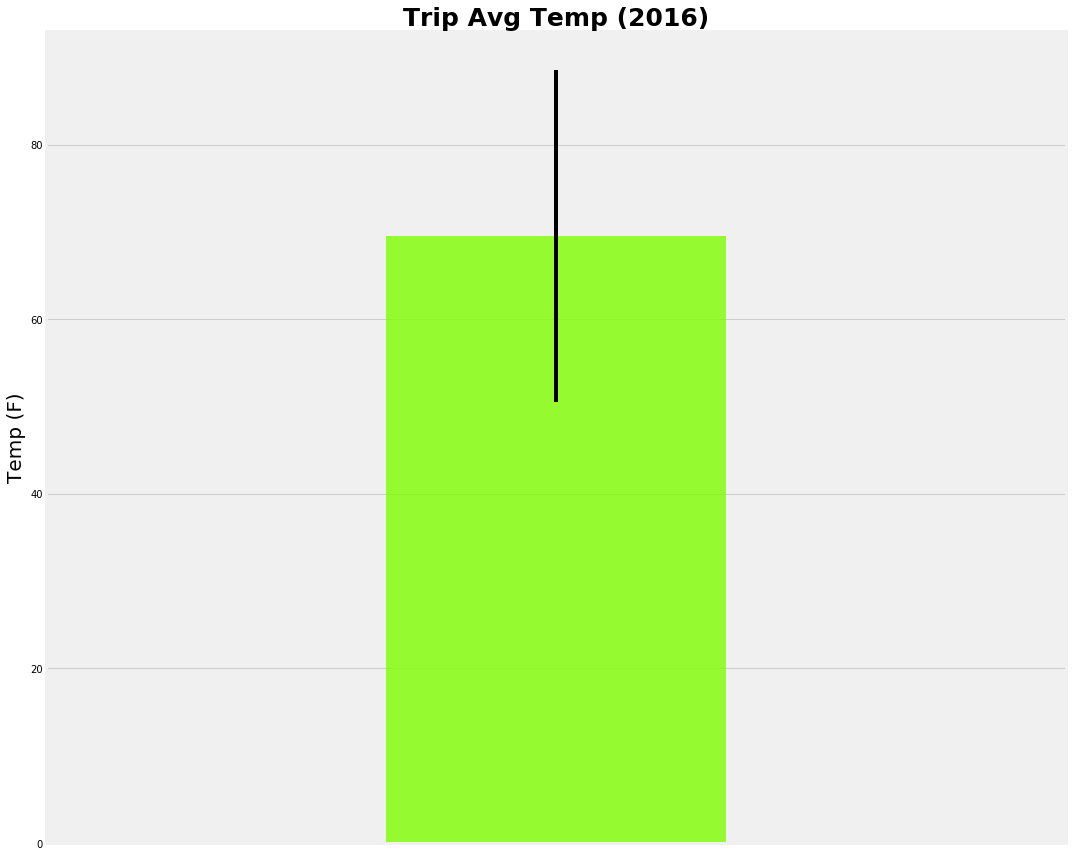

In [27]:
# •••••••••••••••••••••••••••••••••••••••••••••••••••• Bar Party •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• #
#   * Plot the min, avg, and max temperature from your previous query as a bar chart.

#   * Use the average temperature as the bar height.

#   * Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

p2p = yr1avgtemp[0][2]-yr1avgtemp[0][0]
avgtemp = yr1avgtemp[0][1]
mintemp = yr1avgtemp[0][0]
maxtemp = yr1avgtemp[0][2]
plt.figure(figsize = (15,12))
plt.title("Trip Avg Temp (2016)", fontdict = {'fontsize': 25, 'fontweight': 'bold'})
plt.bar( 1,avgtemp, color = 'chartreuse', alpha=0.80, yerr = maxtemp-mintemp)
plt.xlim(-0.2, 2.2)
plt.axes().get_xaxis().set_visible(False)
plt.ylabel("Temp (F)", fontdict = {'fontsize': 20})
plt.tight_layout()
plt.show()

## Daily Rainfall Average

In [28]:
# * Calculate the rainfall per weather station using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def rainfall(start_date, end_date):
    """Calculates the rainfall per weather station
    
        Args:
            start_date (string): A date string in the format %Y-%m-%d
            end_date (string): A date string in the format %Y-%m-%d
        
        Returns: *In descending order* 
                  A list of tuples with rainfall (precipiation), station & name, lat/long, and elevation.
            """         
    
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(
            Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

print(rainfall('2016-01-28','2016-02-07'))

[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.0), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, None)]


In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples with daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

### Daily Normals - Calculation Requirements

In [30]:
# * Calculate the daily normals. Normals are the averages for the min, avg, and max temperatures.
# * Then, push each tuple of calculations into a list called `normals`


# Set the start and end date of the trip
start = '2017-01-28'
end ='2017-02-07'

# Use the start and end date to create a range of dates
daterg = session.query(Measurement.date).filter(Measurement.date >= start).filter(
        Measurement.date <= end).group_by(Measurement.date).all()

# K, now let's get the info from the query 
trips = [x[0] for x in daterg]

# Strip off the year and save a list of %m-%d strings
striptrips = [x[5:] for x in trips]

# Find the start month/day and the end month/day 
startmd= striptrips[0]
endmd = striptrips[-1]

# Loop through the list of %m-%d strings and calculate the normals for each date    
normals = [session.query(func.min(Measurement.tobs),
                       func.avg(Measurement.tobs),
                       func.max(Measurement.tobs)).filter(
                       func.strftime("%m-%d", Measurement.date)>= startmd).filter(
                       func.strftime("%m-%d", Measurement.date) <= endmd).group_by(
                       func.strftime("%m-%d", Measurement.date)).all()]

normals = normals[0]
print("Daily Normals 1/28/17 to 2/7/17")
normals

Daily Normals 1/28/17 to 2/7/17


[(62.0, 69.03703703703704, 77.0),
 (64.0, 69.14, 76.0),
 (60.0, 67.12962962962963, 77.0),
 (60.0, 68.47368421052632, 74.0),
 (56.0, 68.14035087719299, 78.0),
 (59.0, 68.85964912280701, 77.0),
 (58.0, 67.79661016949153, 77.0),
 (61.0, 68.14035087719299, 76.0),
 (59.0, 69.6842105263158, 80.0),
 (58.0, 70.38983050847457, 77.0),
 (60.0, 69.0, 77.0)]

In [31]:
# * Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.
normals_df= pd.DataFrame(data = normals,columns=['tmin', 'tavg', 'tmax'])
normals_df

#K, now add in the dates so we can index the DataFrame to the Trip Date
normals_df['date']= trips
normals_df

# We need an x axis so we can label and size. Change the datatype from element to datetime. 
normals_df['date'] = pd.to_datetime(normals_df['date'], format='%Y-%m-%d')
normals_df

# K, now index the DataFrame to the date
normals_df.set_index('date',inplace=True)
normals_df

,tmin,tavg,tmax
date,,,
2017-01-28,62.0,69.037037,77.0
2017-01-29,64.0,69.140000,76.0
2017-01-30,60.0,67.129630,77.0
2017-01-31,60.0,68.473684,74.0
2017-02-01,56.0,68.140351,78.0
2017-02-02,59.0,68.859649,77.0
2017-02-03,58.0,67.796610,77.0
2017-02-04,61.0,68.140351,76.0
2017-02-05,59.0,69.684211,80.0


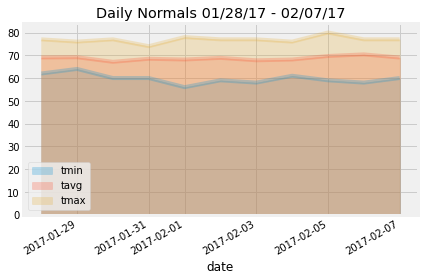

In [32]:
# •••••••••••••••••••••••••••••••••••••••••••••••••••• AreaPlotteration •••••••••••••••••••••••••••••••••••••••••••••••••••••• #
# * Use Pandas to plot an area plot (`stacked=False`) for the daily normals.
normals_df.plot(kind='area', alpha=.25, stacked=False, x_compat=True, title="Daily Normals 01/28/17 - 02/07/17")
plt.tight_layout()
plt.show()